# Week 4, Lesson 4, Activity 7: End-to-end topic classification

&copy;2021, Ekaterina Kochmar \
(updated to newer library versions: Nadejda Roubtsova, February 2022)

Your task in this activity is to:

- Implement a topic classification algorithm and apply it to the set of `20 Newsgroups` posts specified in this notebook.

## Step 1: Data loading

First, let's import the libraries that we are going to use in this notebook. Then, let's define a method to load *training* and *test* subsets using a predefined list of categories. Note that following options are also available:
- you can use `load_dataset('all', categories)` to load the whole dataset
- you can use `load_dataset('train', None)` to load the set of all topics

In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

def load_dataset(a_set, cats):
    dataset = fetch_20newsgroups(subset=a_set, categories=cats,
                          remove=('headers', 'footers', 'quotes'),
                          shuffle=True)
    return dataset

categories = ["comp.windows.x", "misc.forsale", "rec.autos", "rec.motorcycles", "rec.sport.baseball"]
categories += ["rec.sport.hockey", "sci.crypt", "sci.med", "sci.space", "talk.politics.mideast"]

# Apply load_dataset to the training subset
newsgroups_train = load_dataset(a_set='train', cats=categories)

# Apply load_dataset to the testing subset
newsgroups_test = load_dataset(a_set='test', cats=categories)


Let's check what is contained in the uploaded data subsets:

In [3]:
def check_data(dataset):
    print(list(dataset.target_names))  # names of the categories
    print("Number of texts:", dataset.filenames.shape[0])  # the number of texts in the dataset
    print("Number of target labels:", dataset.target.shape[0])  # the number of target labels
    
    # Check that the sizes of both the data (number of texts) and labels (number of targets) is equal
    if dataset.filenames.shape[0] == dataset.target.shape[0]:
        print("Equal sizes for data and targets")
    
    print("First file name and location:", dataset.filenames[0])  # name and location of the file
    print("First data point text:", dataset.data[0])  # print the first data point text
    
    print("First 10 target labels:", dataset.target[:10])  # print out the first 10 target labels

# Now calling the check_data function for both the train and test datasets
check_data(newsgroups_train)
print("\n***\n")
check_data(newsgroups_test)

['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'talk.politics.mideast']
Number of texts: 5913
Number of target labels: 5913
Equal sizes for data and targets
First file name and location: /Users/leon/scikit_learn_data/20news_home/20news-bydate-train/rec.sport.baseball/102665
First data point text: I have posted the logos of the NL East teams to alt.binaries.pictures.misc 
 Hopefully, I'll finish the series up next week with the NL West.

 Darren

First 10 target labels: [4 3 9 7 4 3 0 5 7 8]

***

['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'talk.politics.mideast']
Number of texts: 3937
Number of target labels: 3937
Equal sizes for data and targets
First file name and location: /Users/leon/scikit_learn_data/20news_home/20news-bydate-test/misc.forsale/76785
First data point text: As the tit

## Step 2: ML pipeline with sklearn

Now let's create word vectors based on the content of the posts:

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

def text2vec(vectorizer, train_set, test_set):
    # Fit the vectorizer to the training set and transform it
    vectors_train = vectorizer.fit_transform(train_set.data)
    # Transform the test set
    vectors_test = vectorizer.transform(test_set.data)  # Complete this line to apply vectorizer to the test_set data
    return vectors_train, vectors_test

# Apply the function to the relevant data structures
vectors_train, vectors_test = text2vec(vectorizer, newsgroups_train, newsgroups_test)

Let's check how the data looks like now:

In [5]:
print("Shape of vectors_train:", vectors_train.shape)

# Print the shape of the vectors_test to compare it with the vectors_train
print("Shape of vectors_test:", vectors_test.shape)

# Print the first vector of the training data in a dense format
# Note: vectors_train is in a sparse format by default, you might want to convert it to dense format for better readability or inspection
print("First vector of training data (in dense format):", vectors_train[0].todense())

# Assuming the request to print a specific feature name with index 33404 might not match the actual number of features
# Let's safely access a feature name within the bounds
feature_index = 33404 if 33404 < vectors_train.shape[1] else 0  # Fallback to 0 if 33404 is out of bounds
print(f"Feature name at index {feature_index}:", vectorizer.get_feature_names_out()[feature_index])


Shape of vectors_train: (5913, 52746)
Shape of vectors_test: (3937, 52746)
First vector of training data (in dense format): [[0. 0. 0. ... 0. 0. 0.]]
Feature name at index 33404: nl


## Step 3: Apply a machine learning classifier to the data

Next, let's apply the Multinomial Naive Bayes classifier:

In [6]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1)
clf.fit(vectors_train, newsgroups_train.target)
predictions = clf.predict(vectors_test)

## Step 4: Evaluate the results

Finally, let's evaluate the results, extract the most informative terms per topic, and print out and visualise the confusion matrix. What can you say about the final results?

In [9]:
from sklearn import metrics

def show_top(classifier, categories, vectorizer, n):
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    for i, category in enumerate(categories):
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print(f'{category}: {" ".join(feature_names[top])}')
        

full_report = metrics.classification_report(newsgroups_test.target, 
                                            predictions, target_names=newsgroups_test.target_names)
print(full_report)
# Show the top 10 most informative words for each category
show_top(clf, newsgroups_test.target_names, vectorizer, 10)

                       precision    recall  f1-score   support

       comp.windows.x       0.92      0.90      0.91       395
         misc.forsale       0.88      0.87      0.87       390
            rec.autos       0.83      0.78      0.80       396
      rec.motorcycles       0.85      0.80      0.83       398
   rec.sport.baseball       0.92      0.84      0.88       397
     rec.sport.hockey       0.71      0.94      0.81       399
            sci.crypt       0.82      0.85      0.83       396
              sci.med       0.92      0.82      0.87       396
            sci.space       0.86      0.82      0.84       394
talk.politics.mideast       0.86      0.90      0.88       376

             accuracy                           0.85      3937
            macro avg       0.86      0.85      0.85      3937
         weighted avg       0.86      0.85      0.85      3937

comp.windows.x: program using application windows widget use thanks motif server window
misc.forsale: asking email 

Further evaluation using confusion matrices and visualisation:

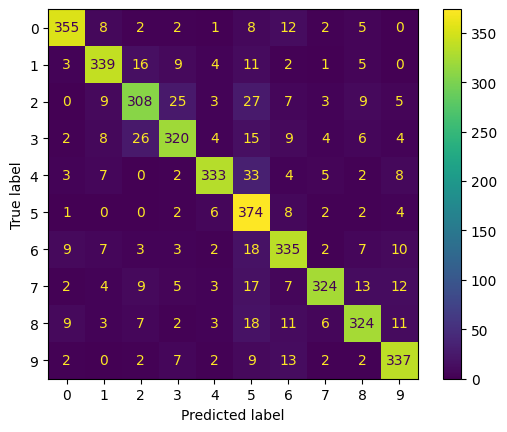

0 comp.windows.x
1 misc.forsale
2 rec.autos
3 rec.motorcycles
4 rec.sport.baseball
5 rec.sport.hockey
6 sci.crypt
7 sci.med
8 sci.space
9 talk.politics.mideast


In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

classifier = clf.fit(vectors_train, newsgroups_train.target)
ConfusionMatrixDisplay.from_estimator(classifier, vectors_test, newsgroups_test.target)
plt.show()

for i, category in enumerate(newsgroups_train.target_names):
    print(i, category)